Reformat sine/pulse data from Pacheco et al. 2019 into csv file.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat

from disp import set_font_size

FPS = 2
DT = 1/FPS

EXPT_DIR = 'data/original/pacheco_neur/'
MAT_FILE = 'median_auditory_responses_wildtype.mat'
# MAT_FILE = 'median_auditory_responses_wildtype_plus_naturalsong.mat'

Load data

In [2]:
temp = loadmat(os.path.join(EXPT_DIR, MAT_FILE))['dataset']
d = dict(zip([k for k, v in temp.dtype.descr], temp[0, 0]))
print(d.keys())

dict_keys(['description', 'median_z_scored_signal_per_roi', 'median_dfof_signal_per_roi', 'timestamps', 'stimuli_index_vector', 'stimuli_name_string', 'response_type_label_per_roi', 'neuropil_index_per_roi', 'neuropil_full_names', 'fly_index_per_roi', 'sex_index_per_roi', 'sex_full_name_string'])


In [3]:
nt = d['timestamps'].shape[1]
nt_wdw = nt//3

mt_stim = d['stimuli_index_vector'].flatten()[:nt_wdw] > 0
print(mt_stim)
ilb = mt_stim.nonzero()[0][0]
iub = ilb + np.sum(mt_stim)
print(ilb, iub)

t = np.arange(len(mt_stim)) * DT - 10
print(t)

lb = t[ilb]
ub = t[iub]
print(lb, ub)

[False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False]
20 41
[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.   12.5  13.   13.5
  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5
  20. ]
0.0 10.5


In [4]:
print(d['median_z_scored_signal_per_roi'].shape)  # num rois (aggregated over flies) x num timesteps
med_rsp_orig = d['median_z_scored_signal_per_roi']
nroi = len(med_rsp_orig)

med_rsp = np.nan * np.zeros((nroi, 2, nt_wdw))
for croi, rsp in enumerate(med_rsp_orig):
    rsp_s = rsp[nt_wdw:2*nt_wdw]
    rsp_p = rsp[:nt_wdw]
    
    std_total = np.std(rsp)
    
    med_rsp[croi, 0, :] = rsp_s / std_total  # sine
    med_rsp[croi, 1, :] = rsp_p / std_total  # pulse
    
    # subtract mean of pre-stim period
    med_rsp[croi, 0, :] -= med_rsp[croi, 0, :ilb].mean()
    med_rsp[croi, 1, :] -= med_rsp[croi, 1, :ilb].mean()
    
print(med_rsp.shape)

(19036, 183)
(19036, 2, 61)


In [5]:
neuropil_idxs = d['neuropil_index_per_roi'].flatten()
print(neuropil_idxs, neuropil_idxs.shape)

[0 1 0 ... 3 0 7] (19036,)


In [6]:
fly_idxs = d['fly_index_per_roi'].flatten()
print(fly_idxs, fly_idxs.shape)

[ 1  1  1 ... 47 47 47] (19036,)


In [7]:
response_type_labels = d['response_type_label_per_roi'].flatten()
print(response_type_labels, response_type_labels.shape)

[13 13 13 ... 18 15 12] (19036,)


In [8]:
neuropil_names = d['neuropil_full_names'].flatten()
neuropil_names = np.array([name_arr[0] for name_arr in neuropil_names])
print(neuropil_names, neuropil_names.shape)

['AMMC' 'SAD' 'GNG' 'WED' 'AVLP' 'PVLP' 'PLP' 'AOTU' 'AL' 'MB_VL' 'MB_ML'
 'MB_PED' 'MB_CA' 'LH' 'EB' 'FB' 'PB' 'NO' 'BU' 'LAL' 'SLP' 'SIP' 'SMP'
 'CRE' 'SCL' 'ICL' 'IB' 'ATL' 'VES' 'EPA' 'GOR' 'SPS' 'IPS' 'FLA' 'CAN'
 'PRW' 'mALT' 'GC' 'WEDC' 'iSADC' 'sSADC'] (41,)


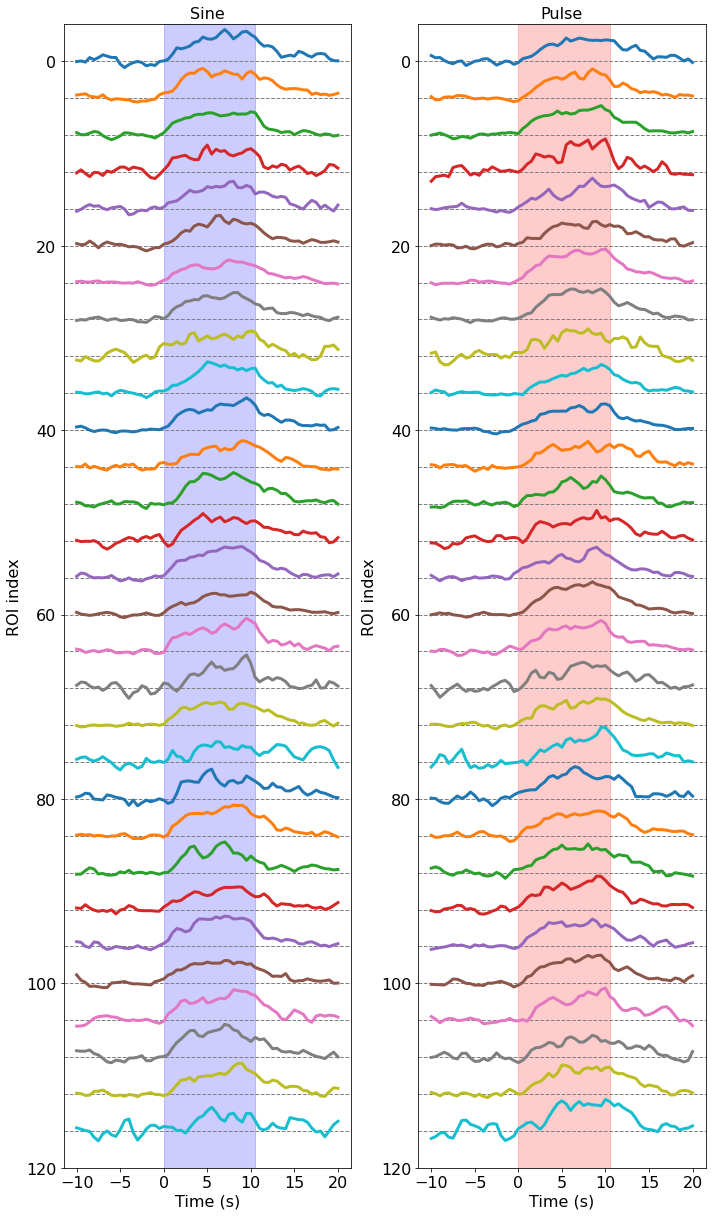

In [9]:
nroi_plot = 30

fig, axs = plt.subplots(1, 2, figsize=(10, 17), tight_layout=True)
for ctr in range(nroi_plot):
    axs[0].axhline(4*ctr, lw=1, ls='--', c='gray')
    axs[0].plot(t, -med_rsp[ctr, 0, :] + 4*ctr, lw=3)
    axs[1].axhline(4*ctr, lw=1, ls='--', c='gray')
    axs[1].plot(t, -med_rsp[ctr, 1, :] + 4*ctr, lw=3)

for ax, c, stim in zip(axs, ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(t[ilb], t[iub], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(4*30, -4)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('ROI index')

set_font_size(axs, 16)

In [10]:
import pandas as pd

named_cols = ['EXPT_ID', 'STIM', 'FLY', 'NEUROPIL', 'NEUROPIL_IDX', 'RESPONSE_TYPE_LABEL']
t_cols = [f'IT_{it}' for it in range(len(t))]
columns = named_cols + t_cols

data = []
for croi, (rsp_s, rsp_p) in enumerate(med_rsp):
    
    row_s = {  # sine response
        'EXPT_ID': croi,
        'STIM': 'S',
        'FLY': fly_idxs[croi],
        'NEUROPIL_IDX': neuropil_idxs[croi],
        'NEUROPIL': neuropil_names[neuropil_idxs[croi]-1],
        'RESPONSE_TYPE_LABEL': response_type_labels[croi],
    }
    
    row_p = {  # pulse response
        'EXPT_ID': croi,
        'STIM': 'P',
        'FLY': fly_idxs[croi],
        'NEUROPIL_IDX': neuropil_idxs[croi],
        'NEUROPIL': neuropil_names[neuropil_idxs[croi]-1],
        'RESPONSE_TYPE_LABEL': response_type_labels[croi],
    }
    
    for ct, t_col in enumerate(t_cols):
        row_s[t_col] = rsp_s[ct]
        row_p[t_col] = rsp_p[ct]
        
    data.append(row_s)
    data.append(row_p)
        
df_med_rsp = pd.DataFrame(columns=columns, data=data)
df_med_rsp.to_csv('data/simple/neur/pacheco.csv', index=False)

In [11]:
df_med_rsp

,EXPT_ID,STIM,FLY,NEUROPIL,NEUROPIL_IDX,RESPONSE_TYPE_LABEL,IT_0,IT_1,IT_2,IT_3,...,IT_51,IT_52,IT_53,IT_54,IT_55,IT_56,IT_57,IT_58,IT_59,IT_60
0,0,S,1,sSADC,0,13,-0.033654,0.039349,-0.090484,0.401704,...,1.082081,0.920516,0.633192,0.459923,0.777835,0.852022,0.777709,0.278367,0.074631,0.042462
1,0,P,1,sSADC,0,13,0.617594,0.378234,0.414807,0.080734,...,0.246901,0.488439,0.480255,0.425880,0.650568,0.628899,0.368041,0.032336,0.248447,-0.126652
2,1,S,1,AMMC,1,13,0.336833,0.408993,0.474425,0.213802,...,1.001931,0.897849,0.874968,0.410459,0.555852,0.387268,0.438035,0.307526,0.391527,0.531009
3,1,P,1,AMMC,1,13,0.168264,-0.182815,-0.143902,0.101796,...,0.702984,0.584333,0.336659,0.414276,0.284469,0.080918,0.384536,0.325093,0.335583,0.242322
4,2,S,1,sSADC,0,13,0.261517,0.033362,0.034890,0.212583,...,0.288560,0.482021,0.431282,0.281125,0.085184,-0.035244,0.125191,0.065407,-0.110486,-0.020802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38067,19033,P,47,GNG,3,18,-0.039356,-0.014598,-0.034997,-0.035381,...,0.153143,0.171215,0.112855,0.084740,0.064839,0.034636,0.019822,0.042430,0.048326,0.051901
38068,19034,S,47,sSADC,0,15,0.710741,0.594676,0.427717,0.166460,...,2.247301,1.373531,1.862249,1.769727,1.958070,2.003307,1.319867,1.124926,1.354274,1.268899
38069,19034,P,47,sSADC,0,15,0.662882,0.455962,0.019223,-0.011819,...,1.422577,1.974313,1.708528,1.429057,1.396340,1.190694,0.925789,0.586538,0.335784,0.296388
38070,19035,S,47,PLP,7,12,0.123877,-0.103292,-0.265331,-0.061722,...,0.086945,0.273224,0.522694,0.491431,0.948518,1.173859,1.000480,0.539625,0.273782,-0.010819
